## 1. Import

In [1]:
import re
import string

import pandas as pd
import numpy as np
from urllib.parse import urlparse
import networkx as nx
import tldextract

import category_encoders as ce

import optuna
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

import warnings

warnings.filterwarnings(action="ignore")

## 2. Data Load

In [2]:
# 학습/평가 데이터 로드
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

# '[.]'을 '.'으로 복구
train_df["URL"] = train_df["URL"].str.replace(r"\[\.\]", ".", regex=True)
test_df["URL"] = test_df["URL"].str.replace(r"\[\.\]", ".", regex=True)

In [9]:
train_df.isnull().sum()

ID       0
URL      0
label    0
dtype: int64

In [10]:
train_df["label"].value_counts()

label
0    5430159
1    1564897
Name: count, dtype: int64

## 3. Feature-Engineering (FE)

In [11]:
## 새로운 변수 생성
# URL 길이
train_df["length"] = train_df["URL"].str.len()
test_df["length"] = test_df["URL"].str.len()

# 서브도메인 개수
train_df["subdomain_count"] = train_df["URL"].apply(
    lambda x: (
        len(tldextract.extract(x).subdomain.split("."))
        if tldextract.extract(x).subdomain
        else 0
    )
)
test_df["subdomain_count"] = test_df["URL"].apply(
    lambda x: (
        len(tldextract.extract(x).subdomain.split("."))
        if tldextract.extract(x).subdomain
        else 0
    )
)

# 특수 문자 개수
train_df["special_char_count"] = train_df["URL"].apply(
    lambda x: sum(1 for c in x if c in string.punctuation)
)
test_df["special_char_count"] = test_df["URL"].apply(
    lambda x: sum(1 for c in x if c in string.punctuation)
)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,0,3
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,0,3
2,TRAIN_0000002,nationalfinance.co.om,0,21,0,2
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,0,3
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5


In [12]:
# 문자 개수
# def count_letters(url):
#     num_letters = sum(char.isalpha() for char in url)
#     return num_letters


# 숫자 개수
def count_digits(url):
    num_digits = sum(char.isdigit() for char in url)
    return num_digits


# train_df["num_letters"] = train_df["URL"].apply(count_letters)
# test_df["num_letters"] = test_df["URL"].apply(count_letters)
train_df["num_digits"] = train_df["URL"].apply(count_digits)
test_df["num_digits"] = test_df["URL"].apply(count_digits)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_digits
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,0,3,0
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,0,3,0
2,TRAIN_0000002,nationalfinance.co.om,0,21,0,2,0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,0,3,0
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,2


In [ ]:
# @ 포함 여부
def include_at(url):
    if "@" in url:
        return 1
    return 0


train_df["at_sign"] = train_df["URL"].apply(include_at)
test_df["at_sign"] = test_df["URL"].apply(include_at)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_digits,at_sign
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,0,3,0,0
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,0,3,0,0
2,TRAIN_0000002,nationalfinance.co.om,0,21,0,2,0,0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,0,3,0,0
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,2,0


In [ ]:
# "//" 문자 포함 여부
def include_double_slash(url):
    if "//" in url:
        return 1
    return 0


train_df["double_slash"] = train_df["URL"].apply(include_double_slash)
test_df["double_slash"] = test_df["URL"].apply(include_double_slash)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_digits,at_sign,double_slash
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,0,3,0,0,0
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,0,3,0,0,0
2,TRAIN_0000002,nationalfinance.co.om,0,21,0,2,0,0,0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,0,3,0,0,0
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,2,0,0


In [ ]:
# URL 깊이 반환
def get_url_depth(url):
    path = url.strip("/").split("/")
    return len(path) - 1 if len(path) > 1 else 0


train_df["url_depth"] = train_df["URL"].apply(get_url_depth)
test_df["url_depth"] = test_df["URL"].apply(get_url_depth)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_digits,at_sign,double_slash,url_depth
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,0,3,0,0,0,0
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,0,3,0,0,0,0
2,TRAIN_0000002,nationalfinance.co.om,0,21,0,2,0,0,0,0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,0,3,0,0,0,0
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,2,0,0,2


In [16]:
# # 짧은 링크인지 여부
# shortening_services = (
#     r"bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|"
#     r"yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|"
#     r"short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|"
#     r"doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|db\.tt|"
#     r"qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|q\.gs|is\.gd|"
#     r"po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|x\.co|"
#     r"prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|"
#     r"tr\.im|link\.zip\.net"
# )


# def has_shortening_service(url):
#     match=re.search(shortening_services, url)
#     if match:
#         return 1
#     else:
#         return 0


# train_df["shortened"] = train_df["URL"].apply(has_shortening_service)
# test_df["shortened"] = test_df["URL"].apply(has_shortening_service)

# train_df.head()

In [ ]:
# http 포함 여부
def include_https(url):
    if "http" in url:
        return 1
    return 0


train_df["http"] = train_df["URL"].apply(include_https)
test_df["http"] = test_df["URL"].apply(include_https)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_digits,at_sign,double_slash,url_depth,http
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,0,3,0,0,0,0,0
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,0,3,0,0,0,0,0
2,TRAIN_0000002,nationalfinance.co.om,0,21,0,2,0,0,0,0,0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,0,3,0,0,0,0,0
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,2,0,0,2,0


In [ ]:
# 대문자 포함 여부
def include_uppercase(url):
    if pd.isna(url):
        return 0
    return 1 if any(c.isupper() for c in str(url)) else 0


train_df["uppercase"] = train_df["URL"].apply(include_uppercase)
test_df["uppercase"] = test_df["URL"].apply(include_uppercase)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_digits,at_sign,double_slash,url_depth,http,uppercase
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,0,3,0,0,0,0,0,0
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,0,3,0,0,0,0,0,0
2,TRAIN_0000002,nationalfinance.co.om,0,21,0,2,0,0,0,0,0,0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,0,3,0,0,0,0,0,0
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,2,0,0,2,0,1


In [ ]:
# IP 주소 포함 여부
def include_ip_address(url):
    pattern = re.compile(r"\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}")
    match = pattern.search(url)

    if match:
        return 1
    return 0


train_df["ip_address"] = train_df["URL"].apply(include_ip_address)
test_df["ip_address"] = test_df["URL"].apply(include_ip_address)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_digits,at_sign,double_slash,url_depth,http,uppercase,ip_address
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,0,3,0,0,0,0,0,0,0
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,0,3,0,0,0,0,0,0,0
2,TRAIN_0000002,nationalfinance.co.om,0,21,0,2,0,0,0,0,0,0,0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,0,3,0,0,0,0,0,0,0
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,2,0,0,2,0,1,0


In [20]:
# 파일확장자 포함 여부
def is_excutable(url):
    extensions = [
        ".exe",
        ".scr",
        ".php",
        ".html",
        ".htm",
        ".hwp",
        ".hwpx",
        ".pptx",
        ".docx",
        ".iso",
        ".js",
        ".lnk",
        ".vbs",
        ".xls",
        ".xml",
        ".zip",
        ".xlsx",
    ]
    for ext in extensions:
        if ext in url:
            return 1
    return 0


train_df["excutable"] = train_df["URL"].apply(lambda url: is_excutable(url))
test_df["excutable"] = test_df["URL"].apply(lambda url: is_excutable(url))

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_digits,at_sign,double_slash,url_depth,http,uppercase,ip_address,excutable
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,0,3,0,0,0,0,0,0,0,0
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,0,3,0,0,0,0,0,0,0,0
2,TRAIN_0000002,nationalfinance.co.om,0,21,0,2,0,0,0,0,0,0,0,0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,0,3,0,0,0,0,0,0,0,0
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,2,0,0,2,0,1,0,0


In [21]:
# 타이포스쿼팅 구분
def check_typosquatting(url):
    # 자주 사용되는 브랜드/도메인 목록
    common_brands = {
        "google",
        "facebook",
        "amazon",
        "microsoft",
        "apple",
        "netflix",
        "paypal",
        "twitter",
        "instagram",
        "linkedin",
        "youtube",
        "yahoo",
        "gmail",
        "whatsapp",
        "tiktok",
        "geocities",
        "angelfire",
        "newadvent",
        "wikipedia",
    }

    # 타이포스쿼팅 패턴 점수
    score = 0

    try:
        # URL 파싱
        parsed = urlparse(url if "//" in url else "//" + url)
        domain = parsed.netloc.lower() if parsed.netloc else url.lower()

        # 1. 숫자로 문자 대체 패턴 (예: o -> 0, i -> 1, e -> 3)
        number_substitutions = sum(1 for c in domain if c.isdigit())
        if number_substitutions > 0:
            score += 0.2

        # 2. 유사 브랜드 확인
        for brand in common_brands:
            # 레벤슈타인 거리 계산 (문자열 간 편집 거리)
            if brand not in domain:
                similar = False
                # 비슷한 철자 패턴 확인
                patterns = [
                    brand.replace("o", "0"),
                    brand.replace("i", "1"),
                    brand.replace("l", "1"),
                    brand.replace("e", "3"),
                    brand.replace("a", "4"),
                    brand.replace("s", "5"),
                    brand + "-",
                    brand + "_",
                    brand[:-1],  # 마지막 문자 제거
                    "".join(c + c for c in brand),  # 문자 중복
                ]

                for pattern in patterns:
                    if pattern in domain:
                        similar = True
                        break

                if similar:
                    score += 0.3
                    break

        # 3. 반복되는 문자 패턴
        repeated_chars = re.findall(r"(.)\1{2,}", domain)
        if repeated_chars:
            score += 0.2

        # 4. 특수문자 사용
        special_chars = re.findall(r"[-_.]", domain)
        if len(special_chars) > 2:  # 도메인에 특수문자가 많이 사용된 경우
            score += 0.2

        # 5. 도메인 길이 확인
        if len(domain) > 30:  # 비정상적으로 긴 도메인
            score += 0.1

    except:
        return 0

    return min(score, 1.0)  # 최대 점수는 1.0


# 데이터프레임에 적용
train_df["typosquatting"] = train_df["URL"].apply(check_typosquatting)
test_df["typosquatting"] = test_df["URL"].apply(check_typosquatting)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_digits,at_sign,double_slash,url_depth,http,uppercase,ip_address,excutable,typosquatting
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,0,3,0,0,0,0,0,0,0,0,0.2
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,0,3,0,0,0,0,0,0,0,0,0.2
2,TRAIN_0000002,nationalfinance.co.om,0,21,0,2,0,0,0,0,0,0,0,0,0.0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,0,3,0,0,0,0,0,0,0,0,0.2
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,2,0,0,2,0,1,0,0,0.4


In [ ]:
# 피싱 키워드 포함 여부
def include_fishing_keyword(url):
    keywords = [
        "signin",
        "login",
        "account",
        "update",
        "reset",
        "urgent",
        "alert",
        "security",
        "support",
        "banking",
        "secure",
        "verify",
        "password",
        "payment",
        "customer",
        "service",
        "confirm",
        "approve",
        "activate",
        "activation",
        "member",
        "center",
        "info",
        "identity",
        "register",
        "validation",
        "authenticate",
        "recovery",
        "unblock",
        "resolution",
        "unlock",
        "verification",
        "bank",
        "transfer",
        "card",
        "free",
        "event",
        "prize",
    ]

    url_lower = url.lower()
    for keyword in keywords:
        if keyword in url_lower:
            return 1
    return 0


train_df["fishing_keyword"] = train_df["URL"].apply(include_fishing_keyword)
test_df["fishing_keyword"] = test_df["URL"].apply(include_fishing_keyword)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_digits,at_sign,double_slash,url_depth,http,uppercase,ip_address,excutable,typosquatting,fishing_keyword
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,0,3,0,0,0,0,0,0,0,0,0.2,0
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,0,3,0,0,0,0,0,0,0,0,0.2,0
2,TRAIN_0000002,nationalfinance.co.om,0,21,0,2,0,0,0,0,0,0,0,0,0.0,0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,0,3,0,0,0,0,0,0,0,0,0.2,0
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,2,0,0,2,0,1,0,0,0.4,1


In [ ]:
# URL 구성 요소 파싱
def parse_url_components(url):
    try:
        parsed = urlparse(url if "//" in url else "//" + url)
        domain = parsed.netloc
        extracted = tldextract.extract(domain)

        components = {
            "domain": domain,
            "path": parsed.path,
            "params": parsed.params,
            "query": parsed.query,
            "fragment": parsed.fragment,
            "tld": extracted.suffix,
            "sld": extracted.domain,
            "subdomain": extracted.subdomain,
        }

        return components

    except:
        return {
            "domain": "",
            "path": "",
            "params": "",
            "query": "",
            "fragment": "",
            "tld": "",
            "sld": "",
            "subdomain": "",
        }


for df in [train_df, test_df]:
    components = df["URL"].apply(parse_url_components)

    df["url_path"] = components.apply(lambda x: x["path"])
    # df['url_params'] = components.apply(lambda x: x['params'])
    # df['url_query'] = components.apply(lambda x: x['query'])
    # df['url_fragment'] = components.apply(lambda x: x['fragment'])
    df["url_tld"] = components.apply(lambda x: x["tld"])
    df["url_sld"] = components.apply(lambda x: x["sld"])
    df["url_subdomain"] = components.apply(lambda x: x["subdomain"])

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_digits,at_sign,double_slash,url_depth,http,uppercase,ip_address,excutable,typosquatting,fishing_keyword,url_path,url_tld,url_sld,url_subdomain
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,0,3,0,0,0,0,0,0,0,0,0.2,0,,wuoz.gov.pl,poznan,
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,0,3,0,0,0,0,0,0,0,0,0.2,0,,okawa.kochi.jp,vill,
2,TRAIN_0000002,nationalfinance.co.om,0,21,0,2,0,0,0,0,0,0,0,0,0.0,0,,co.om,nationalfinance,
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,0,3,0,0,0,0,0,0,0,0,0.2,0,,ozora.hokkaido.jp,town,
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,2,0,0,2,0,1,0,0,0.4,1,/online/Login,irish,ie-news,open24


In [24]:
# URL 무작위성
import math
from collections import Counter


def calculate_entropy(url):
    # 문자 빈도수 계산
    counter = Counter(url)
    length = len(url)

    # 섀넌 엔트로피 계산
    entropy = 0
    for count in counter.values():
        probability = count / length
        entropy -= probability * math.log2(probability)
    return entropy


def check_randomness(url):
    # 1. 엔트로피 계산
    entropy = calculate_entropy(url)

    # 2. 연속된 숫자나 문자의 최대 길이
    max_consecutive = 1
    current_consecutive = 1
    for i in range(1, len(url)):
        if (
            url[i].isalnum()
            and url[i - 1].isalnum()
            and url[i].lower() == url[i - 1].lower()
        ):
            current_consecutive += 1
            max_consecutive = max(max_consecutive, current_consecutive)
        else:
            current_consecutive = 1

    # 3. 숫자와 문자의 교차 패턴 수
    transitions = 0
    for i in range(1, len(url)):
        if (url[i - 1].isdigit() and url[i].isalpha()) or (
            url[i - 1].isalpha() and url[i].isdigit()
        ):
            transitions += 1

    # 무작위성 점수 계산 (0~1 사이로 정규화)
    entropy_score = min(entropy / 5.0, 1.0)  # 일반적인 URL의 최대 엔트로피를 5로 가정
    consecutive_score = min(
        max_consecutive / 10.0, 1.0
    )  # 연속된 문자가 많을수록 낮은 점수
    transition_score = min(transitions / 10.0, 1.0)  # 전환이 많을수록 높은 점수

    # 종합 점수 계산 (가중치 조정 가능)
    randomness_score = (
        entropy_score * 0.5 + (1 - consecutive_score) * 0.3 + transition_score * 0.2
    )

    return randomness_score


# 데이터프레임에 적용
train_df["entropy_URL"] = train_df["URL"].apply(check_randomness)
train_df["entropy_path"] = train_df["url_path"].apply(check_randomness)
train_df["entropy_tld"] = train_df["url_tld"].apply(check_randomness)
train_df["entropy_sld"] = train_df["url_sld"].apply(check_randomness)
train_df["entropy_subdomain"] = train_df["url_subdomain"].apply(check_randomness)
test_df["entropy_URL"] = test_df["URL"].apply(check_randomness)
test_df["entropy_path"] = test_df["url_path"].apply(check_randomness)
test_df["entropy_tld"] = test_df["url_tld"].apply(check_randomness)
test_df["entropy_sld"] = test_df["url_sld"].apply(check_randomness)
test_df["entropy_subdomain"] = test_df["url_subdomain"].apply(check_randomness)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_digits,at_sign,double_slash,url_depth,...,fishing_keyword,url_path,url_tld,url_sld,url_subdomain,entropy_URL,entropy_path,entropy_tld,entropy_sld,entropy_subdomain
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,0,3,0,0,0,0,...,0,,wuoz.gov.pl,poznan,,0.600827,0.270000,0.579580,0.495163,0.270000
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,0,3,0,0,0,0,...,0,,okawa.kochi.jp,vill,,0.587135,0.270000,0.593593,0.390000,0.270000
2,TRAIN_0000002,nationalfinance.co.om,0,21,0,2,0,0,0,0,...,0,,co.om,nationalfinance,,0.597280,0.270000,0.462193,0.562323,0.270000
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,0,3,0,0,0,0,...,0,,ozora.hokkaido.jp,town,,0.593377,0.270000,0.566393,0.470000,0.270000
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,2,0,0,2,...,1,/online/Login,irish,ie-news,open24,0.667245,0.557314,0.462193,0.522164,0.548496


In [ ]:
for df in [train_df, test_df]:
    # url_tld, url_sld, url_subdomain 에 - 포함 여부
    df["url_tld_hyphen"] = df["url_tld"].str.contains("-").astype(int)
    df["url_sld_hyphen"] = df["url_sld"].str.contains("-").astype(int)
    df["url_subdomain_hyphen"] = df["url_subdomain"].str.contains("-").astype(int)

    # URL 구성 요소들의 길이
    df["url_path_length"] = df["url_path"].str.len()
    df["url_tld_length"] = df["url_tld"].str.len()
    df["url_sld_length"] = df["url_sld"].str.len()
    df["url_subdomain_length"] = df["url_subdomain"].str.len()

    # URL 구성 요소들의 특수문자 개수
    df["url_path_special_chars"] = df["url_path"].apply(
        lambda x: sum(1 for c in x if c in string.punctuation)
    )
    df["url_tld_special_chars"] = df["url_tld"].apply(
        lambda x: sum(1 for c in x if c in string.punctuation)
    )
    df["url_sld_special_chars"] = df["url_sld"].apply(
        lambda x: sum(1 for c in x if c in string.punctuation)
    )
    df["url_subdomain_special_chars"] = df["url_subdomain"].apply(
        lambda x: sum(1 for c in x if c in string.punctuation)
    )

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_digits,at_sign,double_slash,url_depth,...,url_sld_hyphen,url_subdomain_hyphen,url_path_length,url_tld_length,url_sld_length,url_subdomain_length,url_path_special_chars,url_tld_special_chars,url_sld_special_chars,url_subdomain_special_chars
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,0,3,0,0,0,0,...,0,0,0,11,6,0,0,2,0,0
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,0,3,0,0,0,0,...,0,0,0,14,4,0,0,2,0,0
2,TRAIN_0000002,nationalfinance.co.om,0,21,0,2,0,0,0,0,...,0,0,0,5,15,0,0,1,0,0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,0,3,0,0,0,0,...,0,0,0,17,4,0,0,2,0,0
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,2,0,0,2,...,1,0,13,5,7,6,2,0,1,0


In [26]:
# # URL 구성 요소별 대문자 포함 여부
# train_df['url_path_uppercase'] = train_df['url_path'].apply(include_uppercase)
# train_df['url_tld_uppercase'] = train_df['url_tld'].apply(include_uppercase)
# train_df['url_sld_uppercase'] = train_df['url_sld'].apply(include_uppercase)
# train_df['url_subdomain_uppercase'] = train_df['url_subdomain'].apply(include_uppercase)

# test_df['url_path_uppercase'] = test_df['url_path'].apply(include_uppercase)
# test_df['url_tld_uppercase'] = test_df['url_tld'].apply(include_uppercase)
# test_df['url_sld_uppercase'] = test_df['url_sld'].apply(include_uppercase)
# test_df['url_subdomain_uppercase'] = test_df['url_subdomain'].apply(include_uppercase)

# train_df.head()

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

train_df["tld_phishing_ratio_cv"] = 0
train_df["sld_phishing_ratio_cv"] = 0

for train_idx, val_idx in kf.split(train_df):
    X_train, X_val = train_df.iloc[train_idx], train_df.iloc[val_idx]

    # tld 기준
    pivot_tld = X_train.groupby("url_tld")["label"].mean()
    train_df.loc[val_idx, "tld_phishing_ratio_cv"] = train_df.loc[
        val_idx, "url_tld"
    ].map(pivot_tld)

    # sld 기준
    pivot_sld = X_train.groupby("url_sld")["label"].mean()
    train_df.loc[val_idx, "sld_phishing_ratio_cv"] = train_df.loc[
        val_idx, "url_sld"
    ].map(pivot_sld)

# 결측치는 global 평균으로 채움
train_df["tld_phishing_ratio_cv"].fillna(train_df["label"].mean(), inplace=True)
train_df["sld_phishing_ratio_cv"].fillna(train_df["label"].mean(), inplace=True)

# test_df는 전체 train 기준으로 만든 피벗으로 적용
pivot_tld_full = train_df.groupby("url_tld")["label"].mean()
pivot_sld_full = train_df.groupby("url_sld")["label"].mean()

test_df["tld_phishing_ratio_cv"] = test_df["url_tld"].map(pivot_tld_full)
test_df["sld_phishing_ratio_cv"] = test_df["url_sld"].map(pivot_sld_full)

test_df["tld_phishing_ratio_cv"].fillna(train_df["label"].mean(), inplace=True)
test_df["sld_phishing_ratio_cv"].fillna(train_df["label"].mean(), inplace=True)

# 새 피처 초기화
for col in [
    "sld_phishing_ratio_cv",
    "sld_mean_special_char_cv",
    "keyword_mean_randomness_cv",
    "subdomain_phishing_ratio_cv",
]:
    train_df[col] = 0

# 교차 검증으로 피처 생성 (리키지 방지)
for train_idx, val_idx in kf.split(train_df):
    X_train, X_val = train_df.iloc[train_idx], train_df.iloc[val_idx]

    # url_sld별 피싱 비율, 특수문자 평균
    pivot_sld = X_train.groupby("url_sld").agg(
        {"label": "mean", "special_char_count": "mean"}
    )
    train_df.loc[val_idx, "sld_phishing_ratio_cv"] = train_df.loc[
        val_idx, "url_sld"
    ].map(pivot_sld["label"])
    train_df.loc[val_idx, "sld_mean_special_char_cv"] = train_df.loc[
        val_idx, "url_sld"
    ].map(pivot_sld["special_char_count"])

    # fishing_keyword별 평균 entropy
    pivot_keyword = X_train.groupby("fishing_keyword")["entropy_URL"].mean()
    train_df.loc[val_idx, "keyword_mean_randomness_cv"] = train_df.loc[
        val_idx, "fishing_keyword"
    ].map(pivot_keyword)

    # subdomain_count별 피싱 비율
    pivot_subdomain = X_train.groupby("subdomain_count")["label"].mean()
    train_df.loc[val_idx, "subdomain_phishing_ratio_cv"] = train_df.loc[
        val_idx, "subdomain_count"
    ].map(pivot_subdomain)

# 결측치 처리
train_df["sld_phishing_ratio_cv"].fillna(train_df["label"].mean(), inplace=True)
train_df["sld_mean_special_char_cv"].fillna(
    train_df["special_char_count"].mean(), inplace=True
)
train_df["keyword_mean_randomness_cv"].fillna(
    train_df["entropy_URL"].mean(), inplace=True
)
train_df["subdomain_phishing_ratio_cv"].fillna(train_df["label"].mean(), inplace=True)

# test_df에 적용
pivot_sld_full = train_df.groupby("url_sld").agg(
    {"label": "mean", "special_char_count": "mean"}
)
pivot_keyword_full = train_df.groupby("fishing_keyword")["entropy_URL"].mean()
pivot_subdomain_full = train_df.groupby("subdomain_count")["label"].mean()

test_df["sld_phishing_ratio_cv"] = test_df["url_sld"].map(pivot_sld_full["label"])
test_df["sld_mean_special_char_cv"] = test_df["url_sld"].map(
    pivot_sld_full["special_char_count"]
)
test_df["keyword_mean_randomness_cv"] = test_df["fishing_keyword"].map(
    pivot_keyword_full
)
test_df["subdomain_phishing_ratio_cv"] = test_df["subdomain_count"].map(
    pivot_subdomain_full
)

# 결측치 처리 (test)
test_df["sld_phishing_ratio_cv"].fillna(train_df["label"].mean(), inplace=True)
test_df["sld_mean_special_char_cv"].fillna(
    train_df["special_char_count"].mean(), inplace=True
)
test_df["keyword_mean_randomness_cv"].fillna(
    train_df["entropy_URL"].mean(), inplace=True
)
test_df["subdomain_phishing_ratio_cv"].fillna(train_df["label"].mean(), inplace=True)

# 전체 train 데이터의 피싱 비율 (전체 평균)
global_mean = train_df["label"].mean()

# 교차 검증을 사용해 url_subdomain별 피싱 비율 피처 만들기
train_df["subdomain_phishing_ratio_cv"] = 0
for train_idx, val_idx in kf.split(train_df):
    X_train = train_df.iloc[train_idx]
    pivot_subdomain = X_train.groupby("url_subdomain")["label"].mean()
    train_df.loc[val_idx, "subdomain_phishing_ratio_cv"] = train_df.loc[
        val_idx, "url_subdomain"
    ].map(pivot_subdomain)
train_df["subdomain_phishing_ratio_cv"].fillna(global_mean, inplace=True)

# test_df에도 같은 피처 적용
pivot_subdomain_full = train_df.groupby("url_subdomain")["label"].mean()
test_df["subdomain_phishing_ratio_cv"] = test_df["url_subdomain"].map(
    pivot_subdomain_full
)
test_df["subdomain_phishing_ratio_cv"].fillna(global_mean, inplace=True)

train_df.head()

,ID,URL,label,length,subdomain_count,special_char_count,num_digits,at_sign,double_slash,url_depth,...,url_subdomain_length,url_path_special_chars,url_tld_special_chars,url_sld_special_chars,url_subdomain_special_chars,tld_phishing_ratio_cv,sld_phishing_ratio_cv,sld_mean_special_char_cv,keyword_mean_randomness_cv,subdomain_phishing_ratio_cv
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,0,3,0,0,0,0,...,0,0,2,0,0,0.000000,0.027174,2.750000,0.615153,0.146982
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,0,3,0,0,0,0,...,0,0,2,0,0,0.223715,0.000000,3.039604,0.615146,0.146930
2,TRAIN_0000002,nationalfinance.co.om,0,21,0,2,0,0,0,0,...,0,0,1,0,0,0.142857,0.000000,2.000000,0.615153,0.146982
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,0,3,0,0,0,0,...,0,0,2,0,0,0.000000,0.000000,3.133333,0.615143,0.146863
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,5,2,0,0,2,...,6,2,0,1,0,0.300000,1.000000,3.000000,0.683581,1.000000


In [28]:
train_df.to_csv("data/train_features.csv", index=False)
test_df.to_csv("data/test_features.csv", index=False)

### EDA 

In [3]:
train_df = pd.read_csv("data/train_features.csv")
test_df = pd.read_csv("data/test_features.csv")

In [ ]:
variables = [
    "length",
    "subdomain_count",
    "special_char_count",
    "num_digits",
    "url_depth",
    "typosquatting",
    "entropy_URL",
    "entropy_path",
    "entropy_tld",
    "entropy_sld",
    "entropy_subdomain",
    "url_path_length",
    "url_tld_length",
    "url_sld_length",
    "url_subdomain_length",
    "url_path_special_chars",
    "url_tld_special_chars",
    "url_sld_special_chars",
    "url_subdomain_special_chars",
    "tld_phishing_ratio_cv",
    "sld_phishing_ratio_cv",
    "sld_mean_special_char_cv",
    "subdomain_phishing_ratio_cv",
]



for var in variables:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=train_df, x="label", y=var)
    plt.title(f"Boxplot of {var} by is_malicious")
    plt.xlabel("is_malicious")
    plt.ylabel(var)
    plt.xticks([0, 1], ["Non-Malicious", "Malicious"])
    plt.show()

In [ ]:
variables = [
    "at_sign",
    "double_slash",
    "http",
    "uppercase",
    "ip_address",
    "excutable",
    "fishing_keyword",
    "url_tld_hyphen",
    "url_sld_hyphen",
    "url_subdomain_hyphen",
    "keyword_mean_randomness_cv",
]


for var in variables:
    plt.figure(figsize=(6.4, 4.8))
    ax = sns.countplot(data=train_df, x=var, hue="label")
    for p in ax.patches:
        ax.annotate(
            f"{int(p.get_height())}",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="bottom",
        )

    plt.title(f"Distribution of {var} URLs by Label")
    plt.xlabel(f"Is {var} URL")
    plt.ylabel("Count")
    plt.legend(labels=["Non-Malicious", "Malicious"])
    plt.show()

### 상관 관계 분석

In [ ]:
correlation_matrix = train_df.corr(numeric_only=True)

plt.figure(figsize=(20, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

## 4. Pre-processing (전처리)

In [2]:
train_df = pd.read_csv("data/train_features.csv")
test_df = pd.read_csv("data/test_features.csv")

In [3]:
train_df.isnull().sum()

ID                                   0
URL                                  0
label                                0
length                               0
subdomain_count                      0
special_char_count                   0
num_digits                           0
at_sign                              0
double_slash                         0
url_depth                            0
http                                 0
uppercase                            0
ip_address                           0
excutable                            0
typosquatting                        0
fishing_keyword                      0
url_path                       4880084
url_tld                          36310
url_sld                           7424
url_subdomain                  5499850
entropy_URL                          0
entropy_path                         0
entropy_tld                          0
entropy_sld                          0
entropy_subdomain                    0
url_tld_hyphen           

In [4]:
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

In [5]:
X = train_df.drop(columns=["ID", "label", "URL"])
y = train_df["label"]

X_test = test_df.drop(columns=["ID", "URL"])

### 인코딩

In [6]:
encoder = ce.BinaryEncoder(cols=["url_path", "url_tld", "url_sld", "url_subdomain"])
encoded_X = encoder.fit_transform(X)
encoded_X_test = encoder.transform(X_test)

### 스케일링

In [7]:
def scaling(X, X_test):
    numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns
    scaler = StandardScaler()
    X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
    X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])
    return X, X_test


scaled_X, scaled_X_test = scaling(X, X_test)
encoded_scaled_X, encoded_scaled_X_test = scaling(encoded_X, encoded_X_test)

## 5. K-Fold Model Training (모델 학습)

In [ ]:
# scaled_X_train, scaled_X_valid, scaled_y_train, scaled_y_valid = train_test_split(
#     scaled_X, y
# )
# cat_features = X.select_dtypes(include=["object"]).columns.tolist()

# catboost = CatBoostClassifier(
#     task_type="GPU", eval_metric="AUC", cat_features=cat_features, verbose=100
# )
# catboost.fit(scaled_X_train, scaled_y_train)
# cat_pred = catboost.predict_proba(scaled_X_valid)[:, 1]
# print(
#     classification_report(scaled_y_valid, catboost.predict(scaled_X_valid)),
#     roc_auc_score(scaled_y_valid, cat_pred),
# )

In [ ]:
# (
#     encoded_scaled_X_train,
#     encoded_scaled_X_valid,
#     encoded_scaled_y_train,
#     encoded_scaled_y_valid,
# ) = train_test_split(encoded_scaled_X, y)

# xgboost = XGBClassifier(tree_method="gpu_hist", predictor="gpu_predictor", verbose=100)
# xgboost.fit(encoded_scaled_X_train, encoded_scaled_y_train)
# xgb_pred = xgboost.predict_proba(encoded_scaled_X_valid)[:, 1]
# print(
#     classification_report(
#         encoded_scaled_y_valid, xgboost.predict(encoded_scaled_X_valid)
#     ),
#     roc_auc_score(encoded_scaled_y_valid, xgb_pred),
# )

In [ ]:
# lgbm = LGBMClassifier(device_type="gpu", metric="auc", verbose=-1)
# lgbm.fit(encoded_scaled_X_train, encoded_scaled_y_train)
# xgb_pred = lgbm.predict_proba(encoded_scaled_X_valid)[:, 1]
# print(
#     classification_report(encoded_scaled_y_valid, lgbm.predict(encoded_scaled_X_valid)),
#     roc_auc_score(encoded_scaled_y_valid, xgb_pred),
# )

In [10]:
scaled_X_train, scaled_X_valid, scaled_y_train, scaled_y_valid = train_test_split(scaled_X, y)
encoded_scaled_X_train, encoded_scaled_X_valid, encoded_scaled_y_train, encoded_scaled_y_valid = train_test_split(encoded_scaled_X, y)

cat_features = X.select_dtypes(include=['object']).columns.tolist()

In [8]:
class HyperparameterTuner:
    def __init__(self, model, params, train, target, cat_features=None):
        self.model = model
        self.params = params
        self.train = train
        self.target = target
        self.cat_features = cat_features
        self.cv = KFold(n_splits=3, shuffle=True, random_state=42)
        self.study = optuna.create_study(direction="maximize")

    def objective(self, trial):
        params = {}

        for param_name, param_range in self.params.items():
            if param_range["type"] == "int":
                params[param_name] = trial.suggest_int(
                    param_name, param_range["min"], param_range["max"]
                )
            elif param_range["type"] == "float":
                params[param_name] = trial.suggest_float(
                    param_name, param_range["min"], param_range["max"]
                )
            elif param_range["type"] == "categorical":
                params[param_name] = trial.suggest_categorical(
                    param_name, param_range["values"]
                )
        if self.model == CatBoostClassifier:
            model = self.model(**params, cat_features=self.cat_features)
        else:
            model = self.model(**params)

        model.fit(self.train, self.target)

        scores = cross_val_score(
            model, self.train, self.target, cv=self.cv, scoring="roc_auc"
        ).mean()
        return scores

    def optimize(self, n_trials):
        self.study.optimize(self.objective, n_trials=n_trials)

    def best_params(self):
        return self.study.best_params

    def best_score(self):
        return self.study.best_value

In [11]:
params = {
    "max_depth": {"type": "int", "min": 3, "max": 15},
    "learning_rate": {"type": "float", "min": 0.001, "max": 0.5}, 
    "n_estimators": {"type": "int", "min": 50, "max": 2000},
    "min_child_weight": {"type": "int", "min": 1, "max": 10},
    "gamma": {"type": "float", "min": 0, "max": 2},
    "subsample": {"type": "float", "min": 0.3, "max": 1.0},
    "colsample_bytree": {"type": "float", "min": 0.3, "max": 1.0},
    "reg_alpha": {"type": "float", "min": 0, "max": 2},
    "reg_lambda": {"type": "float", "min": 0, "max": 2},
    "tree_method": {"type": "categorical", "values": ["gpu_hist"]},
    "predictor": {"type": "categorical", "values": ["gpu_predictor"]},
}

xgb_tuner = HyperparameterTuner(
    XGBClassifier, params, encoded_scaled_X_train, encoded_scaled_y_train
)
xgb_tuner.optimize(10)
xgb_tuner.best_params(), xgb_tuner.best_score()

[I 2025-03-21 10:05:06,505] A new study created in memory with name: no-name-de113c2d-f7cb-4290-92a6-ea919f9684a4
[I 2025-03-21 10:11:55,813] Trial 0 finished with value: 0.9868229544784711 and parameters: {'max_depth': 7, 'learning_rate': 0.24843887622005753, 'n_estimators': 1638, 'min_child_weight': 3, 'gamma': 1.0216615575392554, 'subsample': 0.8332994026111673, 'colsample_bytree': 0.9726852617394122, 'reg_alpha': 0.25790201718561456, 'reg_lambda': 0.8698539252550006, 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor'}. Best is trial 0 with value: 0.9868229544784711.
[I 2025-03-21 10:19:19,270] Trial 1 finished with value: 0.9834541470160884 and parameters: {'max_depth': 14, 'learning_rate': 0.30410234505456196, 'n_estimators': 1139, 'min_child_weight': 6, 'gamma': 0.7489016226876941, 'subsample': 0.6924139120702159, 'colsample_bytree': 0.7831054233472778, 'reg_alpha': 0.010346335823243402, 'reg_lambda': 0.49432964646433897, 'tree_method': 'gpu_hist', 'predictor': 'gpu_predicto

({'max_depth': 14,
  'learning_rate': 0.06544945555544966,
  'n_estimators': 679,
  'min_child_weight': 6,
  'gamma': 0.1475788796266655,
  'subsample': 0.7637217944799032,
  'colsample_bytree': 0.3455706517775863,
  'reg_alpha': 1.2853464290269798,
  'reg_lambda': 1.5133344255939427,
  'tree_method': 'gpu_hist',
  'predictor': 'gpu_predictor'},
 0.9877175165641843)

In [14]:
params = {
    'max_depth': 14,
    'learning_rate': 0.06544945555544966,
    'n_estimators': 679,
    'min_child_weight': 6,
    'gamma': 0.1475788796266655,
    'subsample': 0.7637217944799032,
    'colsample_bytree': 0.3455706517775863,
    'reg_alpha': 1.2853464290269798,
    'reg_lambda': 1.5133344255939427,
    'tree_method': 'gpu_hist',
    'predictor': 'gpu_predictor'
}


xgb_tuned = XGBClassifier(**params)
xgb_tuned.fit(encoded_scaled_X_train, encoded_scaled_y_train)
xgb_pred = xgb_tuned.predict_proba(encoded_scaled_X_valid)[:, 1]
print(
    classification_report(
        encoded_scaled_y_valid, xgb_tuned.predict(encoded_scaled_X_valid)
    ),
    roc_auc_score(encoded_scaled_y_valid, xgb_pred),
)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98   1357845
           1       0.97      0.91      0.94    390919

    accuracy                           0.97   1748764
   macro avg       0.97      0.95      0.96   1748764
weighted avg       0.97      0.97      0.97   1748764
 0.9879035178646376


In [12]:
params = {
    "iterations": {"type": "int", "min": 500, "max": 2000},
    "depth": {"type": "int", "min": 4, "max": 12}, 
    "learning_rate": {"type": "float", "min": 0.005, "max": 0.5},
    "l2_leaf_reg": {"type": "float", "min": 0.1, "max": 15},
    "random_strength": {"type": "float", "min": 0.1, "max": 2},
    "bagging_temperature": {"type": "float", "min": 0.2, "max": 2},
    "border_count": {"type": "int", "min": 64, "max": 512},
    "min_data_in_leaf": {"type": "int", "min": 5, "max": 100},
    "task_type": {"type": "categorical", "values": ["GPU"]},
    "eval_metric": {"type": "categorical", "values": ["AUC"]},
    "verbose": {"type": "int", "min": 0, "max": 0},
}

cat_tuner = HyperparameterTuner(
    CatBoostClassifier, params, scaled_X_train, scaled_y_train, cat_features
)
cat_tuner.optimize(5)
cat_tuner.best_params(), cat_tuner.best_score()

[I 2025-03-21 11:06:26,151] A new study created in memory with name: no-name-53141968-c395-4ae0-b857-ee2b2c5cec01
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-03-21 11:38:41,106] Trial 0 finished with value: 0.9902157206343621 and parameters: {'iterations': 711, 'depth': 9, 'learning_rate': 0.2721968393735939, 'l2_leaf_reg': 2.9345449922650193, 'random_strength': 1.102213525748138, 'bagging_temperature': 0.755903932046132, 'border_count': 177, 'min_data_in_leaf': 91, 'task_type': 'GPU', 'eval_metric': 'AUC', 'verbose': 0}. Best is trial 0 with value: 0.9902157206343621.
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC i

({'iterations': 711,
  'depth': 9,
  'learning_rate': 0.2721968393735939,
  'l2_leaf_reg': 2.9345449922650193,
  'random_strength': 1.102213525748138,
  'bagging_temperature': 0.755903932046132,
  'border_count': 177,
  'min_data_in_leaf': 91,
  'task_type': 'GPU',
  'eval_metric': 'AUC',
  'verbose': 0},
 0.9902157206343621)

In [15]:
params = {
    'iterations': 711,
    'depth': 9,
    'learning_rate': 0.2721968393735939,
    'l2_leaf_reg': 2.9345449922650193,
    'random_strength': 1.102213525748138,
    'bagging_temperature': 0.755903932046132,
    'border_count': 177,
    'min_data_in_leaf': 91,
    'task_type': 'GPU',
    'eval_metric': 'AUC',
    'verbose': 0
}


cat_tuned = CatBoostClassifier(**params, cat_features=cat_features)
cat_tuned.fit(scaled_X_train, scaled_y_train)
cat_pred = cat_tuned.predict_proba(scaled_X_valid)[:, 1]
print(
    classification_report(scaled_y_valid, cat_tuned.predict(scaled_X_valid)),
    roc_auc_score(scaled_y_valid, cat_pred),
)

Default metric period is 5 because AUC is/are not implemented for GPU


              precision    recall  f1-score   support

           0       0.98      0.99      0.99   1358258
           1       0.98      0.92      0.95    390506

    accuracy                           0.98   1748764
   macro avg       0.98      0.96      0.97   1748764
weighted avg       0.98      0.98      0.98   1748764
 0.9914797340747159


In [13]:
params = {
    "max_depth": {"type": "int", "min": 4, "max": 12},
    "learning_rate": {"type": "float", "min": 0.005, "max": 0.5}, 
    "n_estimators": {"type": "int", "min": 500, "max": 2000},
    "min_child_samples": {"type": "int", "min": 5, "max": 100},
    "subsample": {"type": "float", "min": 0.2, "max": 1.0},
    "colsample_bytree": {"type": "float", "min": 0.2, "max": 1.0},
    "reg_alpha": {"type": "float", "min": 0.1, "max": 15.0}, 
    "reg_lambda": {"type": "float", "min": 0.1, "max": 15.0},
    "num_leaves": {"type": "int", "min": 20, "max": 100},
    "device_type": {"type": "categorical", "values": ["gpu"]},
    "metric": {"type": "categorical", "values": ["auc"]},
    "verbose": {"type": "int", "min": -1, "max": -1},
    "min_data_in_leaf": {"type": "int", "min": 5, "max": 100}
}

lgbm_tuner = HyperparameterTuner(LGBMClassifier, params, encoded_scaled_X_train, encoded_scaled_y_train)
lgbm_tuner.optimize(10)
lgbm_tuner.best_params(), lgbm_tuner.best_score()

[I 2025-03-21 14:53:20,381] A new study created in memory with name: no-name-3de5f624-3235-4577-9efc-d5c67da4a12e
[I 2025-03-21 15:02:44,447] Trial 0 finished with value: 0.9875954004182246 and parameters: {'max_depth': 5, 'learning_rate': 0.42750218855800504, 'n_estimators': 1098, 'min_child_samples': 87, 'subsample': 0.21464393432989892, 'colsample_bytree': 0.6232666115655594, 'reg_alpha': 8.788551183872048, 'reg_lambda': 14.038359002990578, 'num_leaves': 63, 'device_type': 'gpu', 'metric': 'auc', 'verbose': -1, 'min_data_in_leaf': 64}. Best is trial 0 with value: 0.9875954004182246.
[I 2025-03-21 15:21:50,355] Trial 1 finished with value: 0.9875269740966366 and parameters: {'max_depth': 12, 'learning_rate': 0.2427202174403868, 'n_estimators': 1897, 'min_child_samples': 29, 'subsample': 0.7936144285271747, 'colsample_bytree': 0.3114594735018879, 'reg_alpha': 2.4940249440406146, 'reg_lambda': 13.098328154052425, 'num_leaves': 87, 'device_type': 'gpu', 'metric': 'auc', 'verbose': -1, '

({'max_depth': 8,
  'learning_rate': 0.1847158388458661,
  'n_estimators': 1622,
  'min_child_samples': 99,
  'subsample': 0.9545229500069166,
  'colsample_bytree': 0.3352229148115238,
  'reg_alpha': 6.570096896291103,
  'reg_lambda': 1.8062281002900558,
  'num_leaves': 56,
  'device_type': 'gpu',
  'metric': 'auc',
  'verbose': -1,
  'min_data_in_leaf': 33},
 0.9877789611750488)

In [16]:
params = {'max_depth': 8,
  'learning_rate': 0.1847158388458661,
  'n_estimators': 1622,
  'min_child_samples': 99,
  'subsample': 0.9545229500069166,
  'colsample_bytree': 0.3352229148115238,
  'reg_alpha': 6.570096896291103,
  'reg_lambda': 1.8062281002900558,
  'num_leaves': 56,
  'device_type': 'gpu',
  'metric': 'auc',
  'verbose': -1,
  'min_data_in_leaf': 33}


lgbm_tuned = LGBMClassifier(**params)
lgbm_tuned.fit(encoded_scaled_X_train, encoded_scaled_y_train)
lgbm_pred = lgbm_tuned.predict_proba(encoded_scaled_X_valid)[:, 1]
print(
    classification_report(
        encoded_scaled_y_valid, lgbm_tuned.predict(encoded_scaled_X_valid)
    ),
    roc_auc_score(encoded_scaled_y_valid, lgbm_pred),
)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98   1357845
           1       0.97      0.91      0.94    390919

    accuracy                           0.97   1748764
   macro avg       0.97      0.95      0.96   1748764
weighted avg       0.97      0.97      0.97   1748764
 0.9879071878237695


In [ ]:
# 특성 중요도 시각화
feature_importance = pd.DataFrame({
    'feature': scaled_X.columns,
    'importance': cat_tuned.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('특성 중요도')
plt.xlabel('중요도')
plt.ylabel('특성')
plt.tight_layout()
plt.show()

In [13]:
import shap

explainer = shap.TreeExplainer(cat_tuned)
shap_values = explainer.shap_values(scaled_X_test)

In [22]:
expected_value = explainer.expected_value
n = 1112
shap.initjs()
shap.force_plot(expected_value, shap_values[n], scaled_X_test.iloc[n])

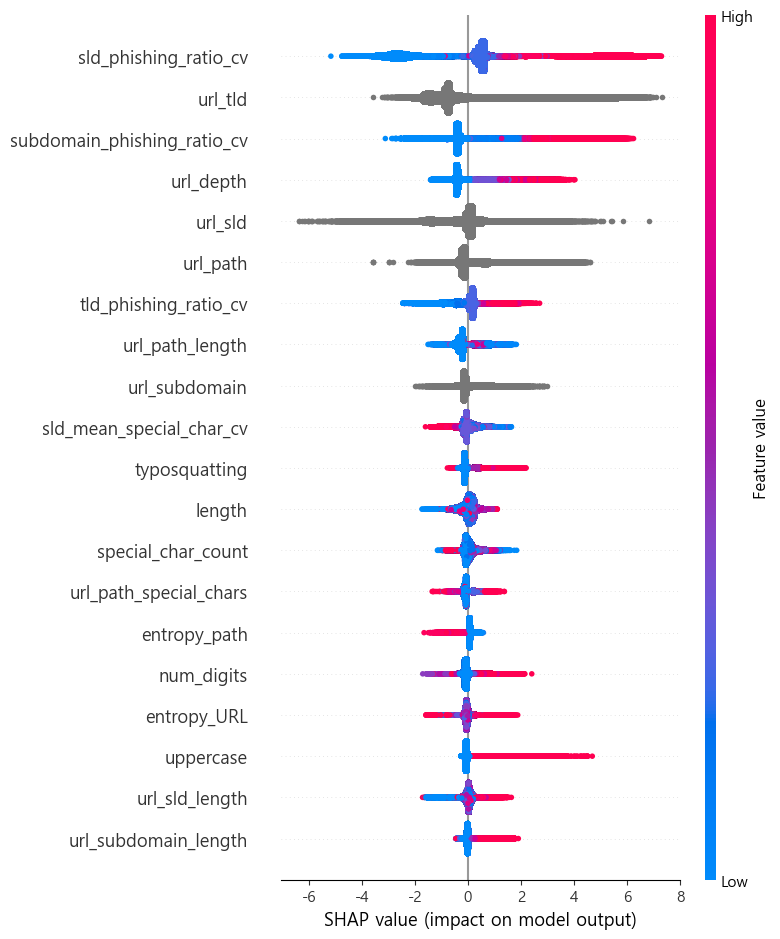

In [23]:
shap.summary_plot(shap_values, scaled_X_test)

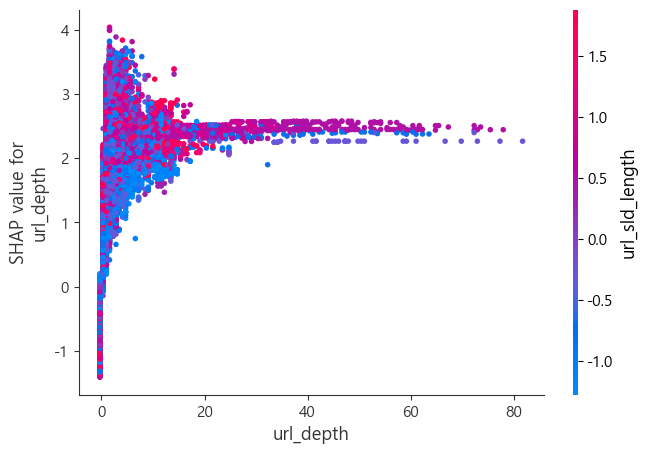

In [31]:
shap.dependence_plot("url_depth", shap_values, scaled_X_test, interaction_index="url_sld_length")

## 6. K-Fold Ensemble Inference (K-Fold 앙상블 추론)

In [17]:
xgb_pred = xgb_tuned.predict_proba(encoded_scaled_X_test)[:, 1]
cat_pred = cat_tuned.predict_proba(scaled_X_test)[:, 1]
lgbm_pred = lgbm_tuned.predict_proba(encoded_scaled_X_test)[:, 1]

ensemble_pred = (xgb_pred + cat_pred + lgbm_pred) / 3
ensemble_pred

array([2.26915362e-03, 4.21625459e-04, 1.16232643e-04, ...,
       1.99928654e-02, 9.19323739e-01, 2.86857002e-03])

## 7. Submission (제출 파일 생성)

In [18]:
test_df["probability"] = ensemble_pred
test_df[["ID", "probability"]].to_csv("data/submission.csv", index=False)